In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import requests
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment',None)

In [2]:
# Define the request headers (taken from Zillow GetSearchPageState API request)
headers = {
    'authority': 'www.zillow.com',
    'accept': '*/*',
    'accept-language': 'es-ES,es;q=0.9,en-US;q=0.8,en;q=0.7',
    'sec-ch-ua': '"Chromium";v="112", "Google Chrome";v="112", "Not:A-Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36',
}


In [3]:
# Function that takes in a request URL and returns a list of dictionaries with the data for the Zillow listings from each result page
def get_data(url):
    response = requests.get(url, headers=headers)
    pages = response.json()['cat1']['searchList']['totalPages']
    data = []
    split = url.split('%22currentPage%22%3A2')
    for page in range(1, pages+1):
        page_url = split[0] + '%22currentPage%22%3A' + str(page) + split[1]
        response = requests.get(page_url, headers=headers)
        data.extend(response.json()['cat1']['searchResults']['listResults'])
    return data

In [ ]:
# Defining the bins for the price range
bins = [i * 20000 for i in range(0, 1001)]

# Generating the request URLs for each price range (to mitigate the 500 maximum results per page limit)
links = ['https://www.zillow.com/search/GetSearchPageState.htm?searchQueryState=%7B%22mapBounds%22%3A%7B%22north%22%3A33.97337635760156%2C%22east%22%3A-115.66360693554688%2C%22south%22%3A32.052726223972044%2C%22west%22%3A-118.02841406445313%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22doz%22%3A%7B%22value%22%3A%2212m%22%7D%2C%22sortSelection%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22isAllHomes%22%3A%7B%22value%22%3Atrue%7D%2C%22isRecentlySold%22%3A%7B%22value%22%3Atrue%7D%2C%22isForSaleByAgent%22%3A%7B%22value%22%3Afalse%7D%2C%22isForSaleByOwner%22%3A%7B%22value%22%3Afalse%7D%2C%22isNewConstruction%22%3A%7B%22value%22%3Afalse%7D%2C%22isComingSoon%22%3A%7B%22value%22%3Afalse%7D%2C%22isAuction%22%3A%7B%22value%22%3Afalse%7D%2C%22isForSaleForeclosure%22%3A%7B%22value%22%3Afalse%7D%2C%22price%22%3A%7B%22min%22%3A' + str(bins[i+1]) + '%2C%22min%22%3A' + str(bins[i]) +'%7D%2C%22monthlyPayment%22%3A%7B%22min%22%3A494%2C%22max%22%3A987%7D%7D%2C%22isListVisible%22%3Atrue%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A2841%2C%22regionType%22%3A4%7D%5D%2C%22pagination%22%3A%7B%22currentPage%22%3A2%7D%2C%22mapZoom%22%3A9%7D&wants={%22cat1%22:[%22listResults%22,%22mapResults%22]}&requestId=12' for i in range(len(bins)-1)]

# Extracting the data of all listings
import tqdm
listings = []
for link in tqdm.tqdm(links):
    listings.extend(get_data(link))

In [ ]:
# Extract the important information from the listings and converting to pandas dataframe
df = pd.DataFrame()
for listing in tqdm.tqdm(listings):
    if 'hdpData' in listing:
        information = listing['hdpData']['homeInfo']
        df = pd.concat([df, pd.DataFrame(information, index=[0])], axis=0)

In [13]:
# Clean the data and save to .csv
df = df.drop_duplicates(subset=['zpid'])
df.reset_index(drop = True, inplace=True)
df.to_csv('zillow_listings.csv', index=False)

In [5]:
# Open the .csv file
data = pd.read_csv('https://raw.githubusercontent.com/david1792x/sd-house-prices/main/zillow_listings.csv', low_memory=False)
pd.set_option('display.max_columns', None)
data.head(10)

,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,dateSold,bathrooms,bedrooms,livingArea,homeType,homeStatus,daysOnZillow,isFeatured,shouldHighlight,zestimate,rentZestimate,listing_sub_type,isUnmappable,isPreforeclosureAuction,homeStatusForHDP,priceForHDP,isNonOwnerOccupied,isPremierBuilder,isZillowOwned,currency,country,taxAssessedValue,lotAreaValue,lotAreaUnit,unit,isRentalWithBasePrice,datePriceChanged,priceReduction,priceChange,videoCount,providerListingID,newConstructionType,contingentListingType,openHouse,open_house_info,comingSoonOnMarketDate
0,16765112,2330 Via Aprilia,92014,Del Mar,CA,32.934574,-117.251900,8500.0,1.680246e+12,4.0,3.0,2899.0,SINGLE_FAMILY,RECENTLY_SOLD,-1,False,False,2759800.0,9650.0,NaN,False,False,RECENTLY_SOLD,8500.0,True,False,False,USD,USA,1340151.0,7840.000000,sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16731749,16938 Via De Santa Fe,92091,Rancho Santa Fe,CA,33.018356,-117.201935,6499.0,1.677917e+12,2.0,2.0,1530.0,CONDO,RECENTLY_SOLD,-1,False,False,1359200.0,3898.0,NaN,False,False,RECENTLY_SOLD,6499.0,True,False,False,USD,USA,557001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82941077,260 E Bradley Ave SPACE 29,92021,El cajon,CA,32.821266,-116.958670,20000.0,1.677139e+12,1.0,2.0,800.0,MANUFACTURED,RECENTLY_SOLD,-1,False,False,NaN,2281.0,NaN,False,False,RECENTLY_SOLD,20000.0,True,False,False,USD,USA,24248.0,2.780000,acres,Space 29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61238050,220 Lyon Cir,92083,Vista,CA,33.192005,-117.238144,3895.0,1.676880e+12,2.5,3.0,1903.0,SINGLE_FAMILY,RECENTLY_SOLD,-1,False,False,828800.0,3792.0,NaN,False,False,RECENTLY_SOLD,3895.0,True,False,False,USD,USA,569249.0,9741.000000,sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16875584,9356 Las Lomas Dr,92071,Santee,CA,32.863760,-117.001550,1000.0,1.675843e+12,2.0,3.0,1676.0,SINGLE_FAMILY,RECENTLY_SOLD,-1,False,False,893100.0,3800.0,NaN,False,False,RECENTLY_SOLD,1000.0,True,False,False,USD,USA,795000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,17201762,17908 Valladares Dr,92127,San Diego,CA,33.037033,-117.078705,3590.0,1.672560e+12,2.0,3.0,1326.0,SINGLE_FAMILY,RECENTLY_SOLD,-1,False,False,841400.0,3510.0,NaN,False,False,RECENTLY_SOLD,3590.0,True,False,False,USD,USA,521122.0,7409.000000,sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2115778161,0 Poway Rd,92064,Poway,CA,NaN,NaN,17600.0,1.671782e+12,NaN,NaN,NaN,LOT,RECENTLY_SOLD,-1,False,False,NaN,2777.0,NaN,False,False,RECENTLY_SOLD,17600.0,True,False,False,USD,USA,NaN,2.020000,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,16580893,1502 Puls St,92058,Oceanside,CA,33.204290,-117.370575,10000.0,1.671523e+12,2.0,4.0,1300.0,SINGLE_FAMILY,RECENTLY_SOLD,-1,False,False,699100.0,4340.0,NaN,False,False,RECENTLY_SOLD,10000.0,True,False,False,USD,USA,477127.0,5220.000000,sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,16809636,11920 Black Mountain Rd UNIT 24,92129,San Diego,CA,32.935734,-117.126950,3590.0,1.671091e+12,2.5,3.0,1510.0,TOWNHOUSE,RECENTLY_SOLD,-1,False,False,826200.0,3497.0,NaN,False,False,RECENTLY_SOLD,3590.0,True,False,False,USD,USA,493161.0,2.639991,acres,Unit 24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,17082839,5893 Chaumont Dr,92114,San Diego,CA,32.724064,-117.070305,7500.0,1.669018e+12,2.0,3.0,1720.0,SINGLE_FAMILY,RECENTLY_SOLD,-1,False,False,756400.0,4104.0,NaN,False,False,RECENTLY_SOLD,7500.0,True,False,False,USD,USA,669119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Select only the important variables and drop listings with missing values
cols = [
    'price',
    'bedrooms',
    'bathrooms',
    'zipcode',
    'latitude',
    'longitude',
    'livingArea',
    'homeType',
    'city'
]
df = data[cols].dropna().reset_index(drop=True)
df.head()

,price,bedrooms,bathrooms,zipcode,latitude,longitude,livingArea,homeType,city
0,8500.0,3.0,4.0,92014,32.934574,-117.251900,2899.0,SINGLE_FAMILY,Del Mar
1,6499.0,2.0,2.0,92091,33.018356,-117.201935,1530.0,CONDO,Rancho Santa Fe
2,20000.0,2.0,1.0,92021,32.821266,-116.958670,800.0,MANUFACTURED,El cajon
3,3895.0,3.0,2.5,92083,33.192005,-117.238144,1903.0,SINGLE_FAMILY,Vista
4,1000.0,3.0,2.0,92071,32.863760,-117.001550,1676.0,SINGLE_FAMILY,Santee


In [5]:
# General information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25023 entries, 0 to 25022
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       25023 non-null  float64
 1   bedrooms    25023 non-null  float64
 2   bathrooms   25023 non-null  float64
 3   zipcode     25023 non-null  int64  
 4   latitude    25023 non-null  float64
 5   longitude   25023 non-null  float64
 6   livingArea  25023 non-null  float64
 7   homeType    25023 non-null  object 
 8   city        25023 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 1.7+ MB


In [6]:
# General statistics about the dataset
df.describe()

,price,bedrooms,bathrooms,zipcode,latitude,longitude,livingArea
count,2.502300e+04,25023.000000,25023.000000,25023.000000,25023.000000,25023.000000,25023.000000
mean,1.052427e+06,3.316189,2.514387,92058.341126,32.894462,-117.126687,1721.322823
std,9.396863e+05,27.322629,9.150478,65.891742,0.193018,0.114507,989.863038
min,5.000000e+02,0.000000,0.000000,91902.000000,32.544020,-117.391190,0.000000
25%,6.100000e+05,2.000000,2.000000,92021.000000,32.744608,-117.223620,1118.000000
50%,8.100000e+05,3.000000,2.000000,92071.000000,32.834576,-117.120970,1481.000000
75%,1.170000e+06,4.000000,3.000000,92114.000000,33.083299,-117.042985,2021.000000
max,2.000000e+07,3705.000000,1440.000000,92620.000000,33.277138,-116.836550,15649.000000


In [14]:
# Cleaning the data by removing outliers and values with errors
df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 15) & (df['bathrooms'] > 0) & (df['bathrooms'] < 15) & (df['livingArea'] > 1000) & (df['livingArea'] < 8000) & (df['price'] > 100000) & (df['price'] < 5000000)]
df = df.sample(frac = 1, random_state=19).reset_index(drop=True)

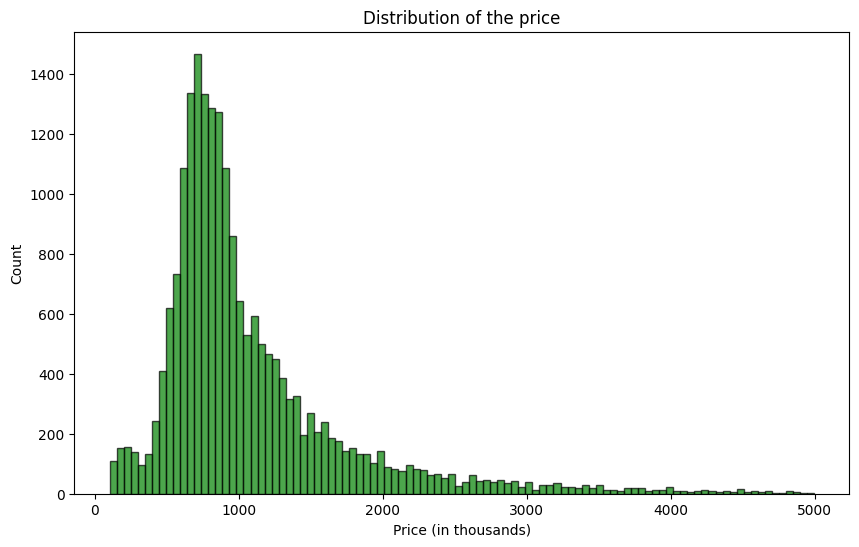

In [8]:
# Plot the distribution of the price
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['price']/1000, bins=100, color = 'green', edgecolor = 'black', alpha = 0.7)
plt.title('Distribution of the price')
plt.xlabel('Price (in thousands)')
plt.ylabel('Count')
plt.show()

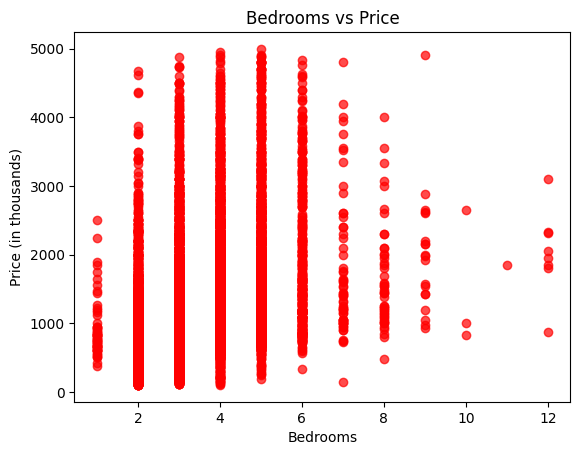

In [9]:
# Plot bedrooms against price
plt.figure()
plt.scatter(df['bedrooms'], df['price']/1000, color = 'red', alpha = 0.7)
plt.title('Bedrooms vs Price')
plt.xlabel('Bedrooms')
plt.ylabel('Price (in thousands)')
plt.show()

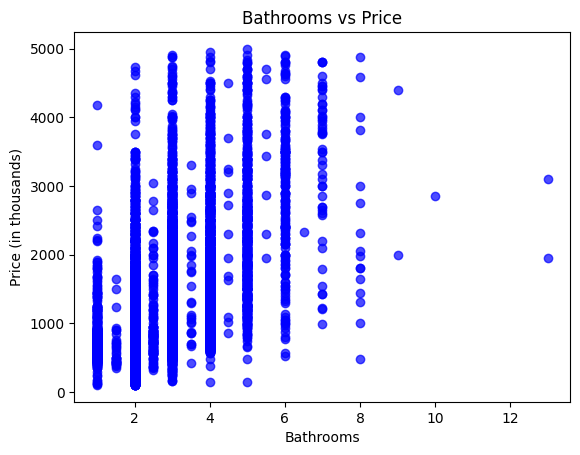

In [10]:
# Plot bathrooms against price
plt.figure()
plt.scatter(df['bathrooms'], df['price']/1000, color = 'blue', alpha = 0.7)
plt.title('Bathrooms vs Price')
plt.xlabel('Bathrooms')
plt.ylabel('Price (in thousands)')
plt.show()

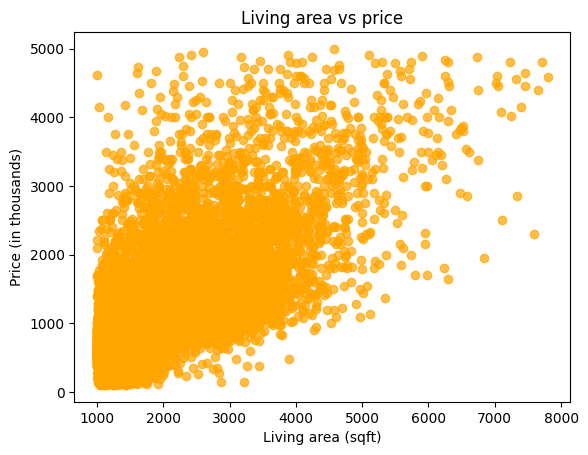

In [11]:
# Plot living area against price
plt.figure()
plt.scatter(df['livingArea'], df['price']/1000, color = 'orange', alpha = 0.7)
plt.title('Living area vs price')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (in thousands)')
plt.show()

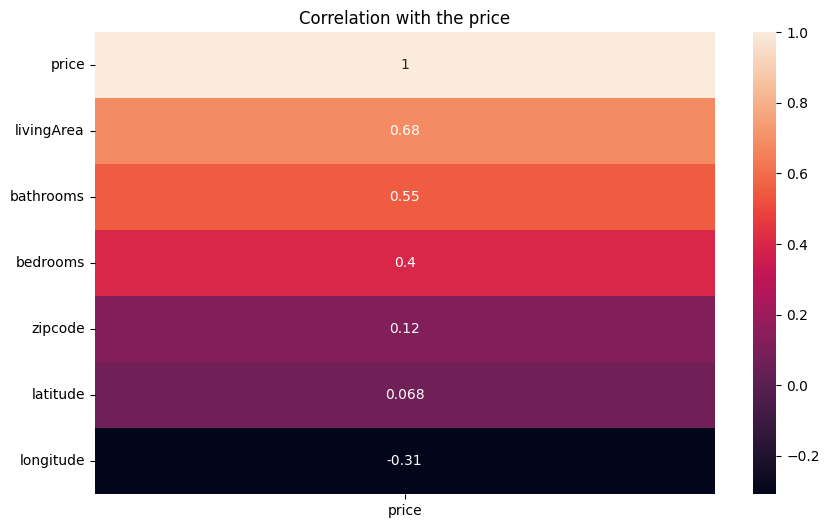

In [12]:
# Plot the correlation with the price only
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True)[['price']].sort_values(by='price', ascending=False), annot=True)
plt.title('Correlation with the price')
plt.show()

In [13]:
# Visualize the distribution of the home types
df['homeType'].value_counts()

SINGLE_FAMILY    13969
CONDO             3316
TOWNHOUSE         1796
MANUFACTURED       840
MULTI_FAMILY       412
APARTMENT          186
LOT                  1
Name: homeType, dtype: int64

In [9]:
# Combine multi-family and townhouse into one category (they are similar)
df['homeType'] = df['homeType'].replace(['MULTI_FAMILY', 'TOWNHOUSE'], 'TOWNHOUSE')

# Remove the only lot listing
df = df[df['homeType'] != 'LOT']

In [15]:
# Visualize the distribution of cities
df['city'].value_counts()

San Diego             7555
Oceanside             1638
Chula Vista           1562
Escondido             1304
Carlsbad              1113
El Cajon              1045
San Marcos             887
Vista                  819
Santee                 610
Spring Valley          539
La Mesa                529
La Jolla               416
Poway                  410
Lakeside               401
Encinitas              375
Coronado               172
Lemon Grove            166
National City          158
Rancho Santa Fe        134
Imperial Beach         128
Solana Beach           122
Bonita                 106
Del Mar                105
Cardiff                 73
Jamul                   56
Ramona                  40
San Ysidro              21
San marcos               5
Chula vista              4
El cajon                 3
Cardiff By The Sea       3
Bonsall                  3
San diego                2
RANCHO SANTA FE          2
Solana beach             1
Spring valley            1
Costa Mesa               1
E

In [10]:
# Define important cities to be included in the analysis with correct spelling
cities = ['San Diego',
 'Oceanside',
 'Chula Vista',
 'Escondido',
 'El Cajon',
 'Carlsbad',
 'San Marcos',
 'Vista',
 'Santee',
 'La Mesa',
 'Spring Valley',
 'La Jolla',
 'Lakeside',
 'Encinitas',
 'Poway',
 'Coronado',
 'Rancho Santa Fe',
 'National City',
 'Lemon Grove',
 'Imperial Beach',
 'Del Mar',
 'Solana Beach',
 'Bonita',
 'Cardiff',
 'Jamul',
 'Ramona',
 'San Ysidro']

# Remove alternate cities
df = df[df['city'].isin(cities)]

In [11]:
# Expand the 'San Diego' city to include neighborhoods and close cities based on zip codes
city_dict = {92101: 'Downtown',
            92128: 'Poway', 
            92117: 'Clairemont', 
            92115: 'La Mesa',
            92130: 'Del Mar', 
            92154: 'San Ysidro',
            92126: 'Poway', 
            92109: 'Point Loma', 
            92114: 'National City', 
            92103: 'Downtown',
            92129: 'Poway', 
            92120: 'La Mesa',
            92131: 'Poway',
            92111: 'Clairemont',
            92104: 'Downtown',
            92108: 'Mission Valley', 
            92122: 'Clairemont',
            92119: 'La Mesa',
            92116: 'Mission Valley',
            92105: 'Downtown', 
            92110: 'Point Loma', 
            92123: 'Mission Valley',
            92139: 'National City',
            92124: 'Mission Valley', 
            92107: 'Point Loma', 
            92102: 'Downtown', 
            92106: 'Point Loma',
            92113: 'Downtown',
            92121: 'Clairemont', 
            92173: 'San Ysidro', 
            92118: 'Coronado',
            92127: 'Rancho Santa Fe'} 

# Change city depending on zip code
df['city'] = df['zipcode'].map(city_dict).fillna(df['city'])

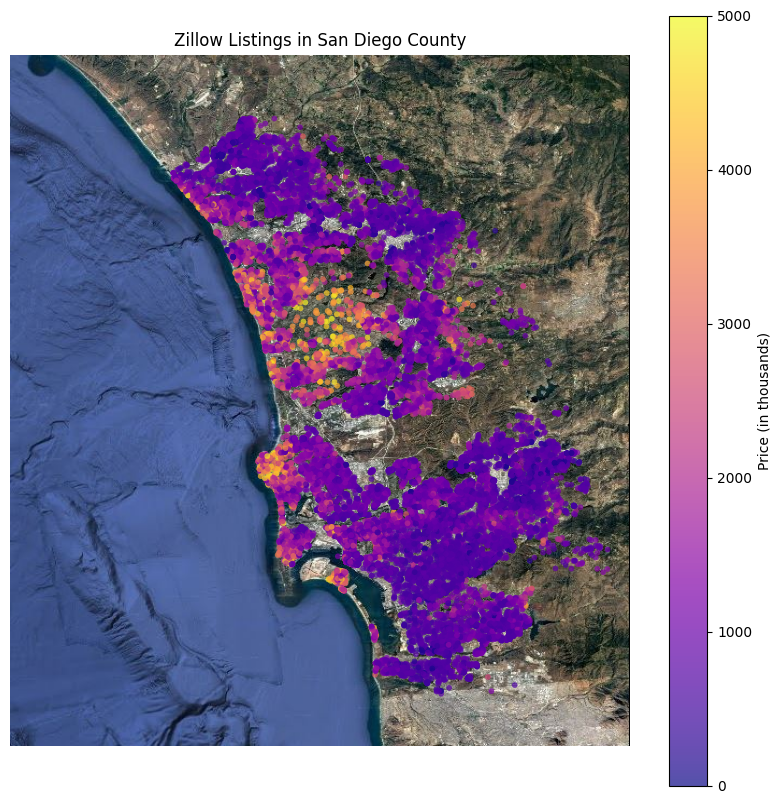

In [18]:
# Graph listings on map
plt.figure(figsize=(10,10))
plt.scatter(df['longitude'], df['latitude'], c=df['price']/1000, cmap='plasma', alpha=0.7, edgecolors='none', s = 17)
plt.colorbar().set_label('Price (in thousands)')
plt.clim(0, 5000)
plt.title('Zillow Listings in San Diego County')
plt.xlim(-117.5976, -116.8080)
plt.ylim(32.477, 33.358)
plt.axis('off')

# Add map image
import PIL as Image
map_image = plt.imread('san_diego.JPG')    
plt.imshow(map_image, extent=[-117.5976, -116.8080, 32.477, 33.358])
plt.show()

In [12]:
# Import preprocessing libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output = "pandas")

# Create preprocessing pipeline
numeric_features = ['bedrooms', 'bathrooms', 'livingArea', 'longitude', 'latitude']
categorical_features = ['homeType', 'city']
preprocessor = ColumnTransformer([('ohe', OneHotEncoder(sparse_output= False), categorical_features),
                                  ('passthrough', 'passthrough' , numeric_features)],
                                remainder = 'drop')

In [42]:
# Import ML libraries
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data into features and target
X = df.drop('price', axis=1)
y = df['price']

# Create pipeline of preprocessing and model (XGBoost with tuned hyperparameters)
pipeline = Pipeline([('preprocessor', preprocessor), ('estimator', XGBRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 200, reg_lambda = 0.1, reg_alpha = 0.1))])

# Test model performance with 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=36)
mae = []
rmse = []
r2 = []
average_error = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae.append(mean_absolute_error(y_test, y_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2.append(r2_score(y_test, y_pred))
    average_error.append(np.mean(np.abs((y_test - y_pred) / y_test)))

print(f'MAE: ${np.mean(mae):.0f}')
print(f'RMSE: ${np.mean(rmse):.0f}')
print(f'R2 score: {np.mean(r2):.4f} or {np.mean(r2)*100:.2f}%')
print(f'Average error: {np.mean(average_error):.4f} or {np.mean(average_error)*100:.2f}%')
print(f'Average error standard deviation: {np.std(average_error):.4f} or {np.std(average_error)*100:.2f}%')

MAE: $146226
RMSE: $248083
R2 score: 0.8634 or 86.34%
Average error: 0.1412 or 14.12%
Average error standard deviation: 0.0025 or 0.25%


In [37]:
# Predict on test set and compare to actual values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).astype(int)
predictions['Error'] = np.abs(predictions['Actual'] - predictions['Predicted'])
predictions['Error (%)'] = np.abs((predictions['Actual'] - predictions['Predicted']) / predictions['Actual'])*100
predictions['Actual'] = predictions['Actual'].map('${:.0f}'.format)
predictions['Predicted'] = predictions['Predicted'].map('${:.0f}'.format)
predictions['Error'] = predictions['Error'].map('${:.0f}'.format)
predictions['Error (%)'] = predictions['Error (%)'].map('{:.2f}%'.format)
predictions.head(10)

,Actual,Predicted,Error,Error (%)
6577,$1585000,$1686247,$101247,6.39%
14922,$1559000,$1532907,$26093,1.67%
20201,$800000,$713347,$86653,10.83%
15134,$795000,$921897,$126897,15.96%
3869,$810000,$837964,$27964,3.45%
863,$1910000,$1735608,$174392,9.13%
3909,$800000,$708037,$91963,11.50%
13075,$755000,$742952,$12048,1.60%
1195,$1770000,$1662835,$107165,6.05%
20472,$525000,$547530,$22530,4.29%


In [41]:
# Get feature importances from model
feature_importances = pd.DataFrame(pipeline['estimator'].feature_importances_, index = pipeline['preprocessor'].get_feature_names_out(), columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
ohe__homeType_MANUFACTURED,0.261593
passthrough__livingArea,0.110888
ohe__city_Coronado,0.100577
ohe__city_Clairemont,0.076101
ohe__city_Carlsbad,0.061977
ohe__city_Poway,0.046483
passthrough__longitude,0.036927
passthrough__latitude,0.035856
ohe__city_Rancho Santa Fe,0.035648
ohe__city_La Jolla,0.034348


In [39]:
# Predict house prices on synthetic data
synthetic_data = pd.DataFrame({'bedrooms': [3, 5, 2],
                                'bathrooms': [2, 3, 2],
                                'livingArea': [1750, 3500, 1500],
                                'homeType': ['SINGLE_FAMILY', 'SINGLE_FAMILY', 'MANUFACTURED'],
                                'city': ['Chula Vista', 'La Jolla', 'Poway'],
                                'longitude': [-117.0032, -117.2549, -117.0407],
                                'latitude': [32.6277, 32.840, 32.9766]})

synthetic_data['predictedPrice'] = pipeline.predict(synthetic_data).astype(int)
synthetic_data

,bedrooms,bathrooms,livingArea,homeType,city,longitude,latitude,predictedPrice
0,3,2,1750,SINGLE_FAMILY,Chula Vista,-117.0032,32.6277,799958
1,5,3,3500,SINGLE_FAMILY,La Jolla,-117.2549,32.8400,3789290
2,2,2,1500,MANUFACTURED,Poway,-117.0407,32.9766,305865


In [43]:
# Save model as pickle file
import pickle
file_name = "sd_pipeline.pkl"

pickle.dump(pipeline, open(file_name, "wb"))